In [3]:
import pandas as pd 
import numpy as np 
import os
from distutils.dir_util import copy_tree, remove_tree
import cv2
import matplotlib.pyplot as plt
import warnings

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow import keras
from random import randint

In [5]:
default_dir = "Combined_dataset/"
root_dir = "./"
#test_dir = default_dir + "test/"
train_dir = default_dir + "train/"
work_dir = root_dir + "dataset/"

if os.path.exists(work_dir):
    remove_tree(work_dir)
    

os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
#copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

Working Directory Contents: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']


In [6]:
CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 176 

IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [7]:
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

image_generator = ImageDataGenerator(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, 
                                     data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

In [8]:
train_dataset = image_generator.flow_from_directory(batch_size=5200,
                                                    directory=work_dir,
                                                    target_size=(176, 176),
                                                    shuffle= True)

Found 10240 images belonging to 4 classes.


##Visualization

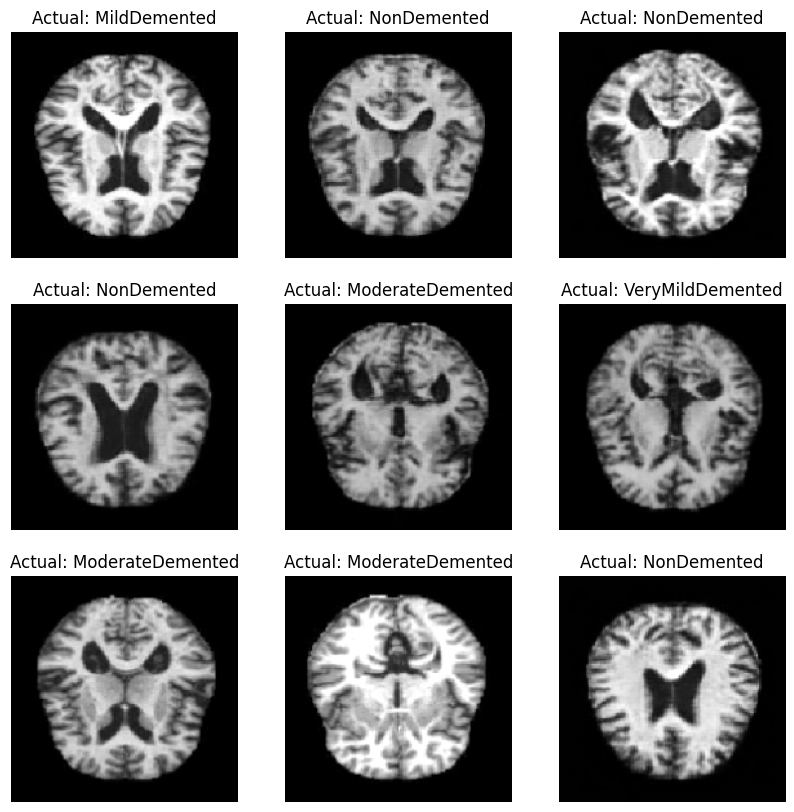

In [15]:
def show_images(generator, y_pred=None):
    labels = dict(zip([0,1,2,3], CLASSES))
    
    # get a batch of images
    x, y = next(generator)
    
    # show a grid of 9 images (first 9 in batch)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(x[i].squeeze(), cmap="gray")
        
        if y_pred is None:
            plt.title(f"Actual: {labels[np.argmax(y[i])]}")
        else:
            plt.title(f"Actual: {labels[np.argmax(y[i])]} \nPredicted: {labels[y_pred[i]]}")
        
        plt.axis("off")
    plt.show()
show_images(train_dataset)


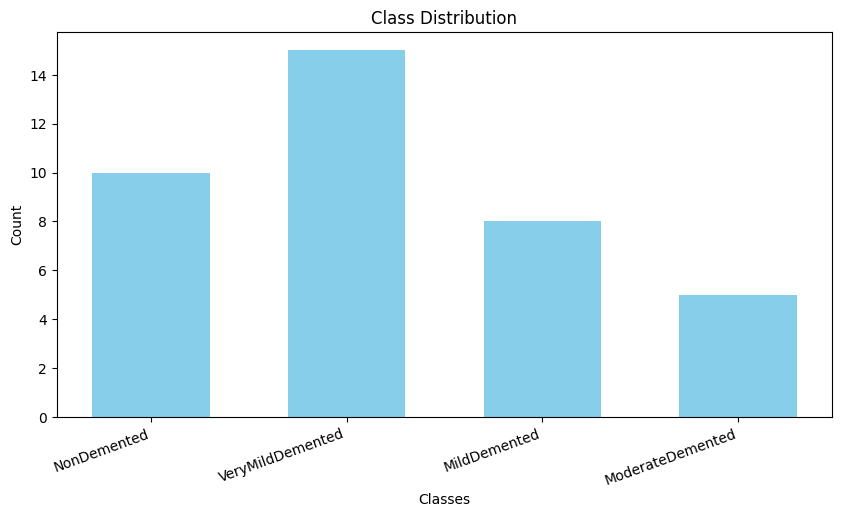

In [23]:
import matplotlib.pyplot as plt
import numpy as np

data = {
    'NonDemented': 10,
    'VeryMildDemented': 15,
    'MildDemented': 8,
    'ModerateDemented': 5
}

# Prepare data
classes = list(data.keys())        
values = list(data.values())       
x = np.arange(len(classes))        

# Plot
plt.figure(figsize=(10, 5))
plt.bar(x, values, color="skyblue", width=0.6)

# Customize
plt.xticks(x, classes, rotation=20, ha="right")
plt.xlabel("Classes")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.show()


In [26]:
train_data, train_labels = next(train_dataset)

In [27]:
print(train_data.shape, train_labels.shape)

(5040, 176, 176, 3) (5040, 4)


In [29]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

augmented_images = []
augmented_labels = []

for x, y in zip(train_data, train_labels):
    x = x.reshape((1, *x.shape))  
    for batch in datagen.flow(x, batch_size=1):
        augmented_images.append(batch[0])
        augmented_labels.append(y)
        if len(augmented_images) + len(train_data) >= 10240:
            break
    if len(augmented_images) + len(train_data) >= 10240:
        break

import numpy as np
train_data = np.concatenate([train_data, np.array(augmented_images)], axis=0)
train_labels = np.concatenate([train_labels, np.array(augmented_labels)], axis=0)

print(train_data.shape, train_labels.shape)


(10240, 176, 176, 3) (10240, 4)


In [30]:
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)


### Training Models

### CNN

In [36]:
from tensorflow.keras import Input, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, SeparableConv2D, BatchNormalization, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(train_data)

classes = np.unique(np.argmax(train_labels, axis=1))
weights = compute_class_weight(class_weight='balanced', classes=classes, y=np.argmax(train_labels, axis=1))
class_weights = dict(zip(classes, weights))

model = Sequential([
    Input(shape=(176, 176, 3)),
    Conv2D(16, (3,3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)),
    MaxPooling2D(),
    Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)),
    MaxPooling2D(),
    SeparableConv2D(64, 3, activation='relu', padding='same', depthwise_regularizer=l2(1e-4), pointwise_regularizer=l2(1e-4)),
    SeparableConv2D(64, 3, activation='relu', padding='same', depthwise_regularizer=l2(1e-4), pointwise_regularizer=l2(1e-4)),
    BatchNormalization(),
    MaxPooling2D(),
    SeparableConv2D(128, 3, activation='relu', padding='same', depthwise_regularizer=l2(1e-4), pointwise_regularizer=l2(1e-4)),
    SeparableConv2D(128, 3, activation='relu', padding='same', depthwise_regularizer=l2(1e-4), pointwise_regularizer=l2(1e-4)),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.3),
    SeparableConv2D(256, 3, activation='relu', padding='same', depthwise_regularizer=l2(1e-4), pointwise_regularizer=l2(1e-4)),
    SeparableConv2D(256, 3, activation='relu', padding='same', depthwise_regularizer=l2(1e-4), pointwise_regularizer=l2(1e-4)),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.3),
    GlobalAveragePooling2D(),
    Dense(256, activation='relu', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(4, activation='softmax')
])

optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

history = model.fit(
    datagen.flow(train_data, train_labels, batch_size=16),
    validation_data=(val_data, val_labels),
    epochs=50,
    class_weight=class_weights,
    callbacks=[es, rlrop]
)

model.summary()


C:\Users\mohit\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 248s 576ms/step - accuracy: 0.4607 - loss: 1.4254 - val_accuracy: 0.6120 - val_loss: 1.4045 - learning_rate: 1.0000e-04
Epoch 2/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 233s 568ms/step - accuracy: 0.6375 - loss: 1.2210 - val_accuracy: 0.2020 - val_loss: 2.9138 - learning_rate: 1.0000e-04
Epoch 3/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 233s 568ms/step - accuracy: 0.6747 - loss: 1.1146 - val_accuracy: 0.6931 - val_loss: 1.0624 - learning_rate: 1.0000e-04
Epoch 4/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 233s 567ms/step - accuracy: 0.6882 - loss: 1.0745 - val_accuracy: 0.1336 - val_loss: 7.1972 - learning_rate: 1.0000e-04
Epoch 5/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 229s 558ms/step - accuracy: 0.7205 - loss: 1.0087 - val_accuracy: 0.1623 - val_loss: 3.3211 - learning_rate: 1.0000e-04
Epoch 6/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 229s 557ms/step - accuracy: 0.7428 - loss: 0.9374 - val_accuracy: 0.1855 - val_loss: 2.1467 - learning_rate: 1.0000e-04
Epoch 7/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 176, 176, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 88, 88, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 88, 88, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 44, 44, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_19                  │ (None, 44, 44, 64)          │           2,400 │
│ (SeparableConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_20                  │ (None, 44, 44, 64)          │           4,736 │
│ (SeparableConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 44, 44, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_21                  │ (None, 22, 22, 128)         │           8,896 │
│ (SeparableConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_22                  │ (None, 22, 22, 128)         │          17,664 │
│ (SeparableConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 22, 22, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 11, 11, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 11, 11, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_23                  │ (None, 11, 11, 256)         │          34,176 │
│ (SeparableConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_24                  │ (None, 11, 11, 256)         │          68,096 │
│ (SeparableConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 11, 11, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 5, 5, 256)           │              

 Total params: 727,438 (2.77 MB)

 Trainable params: 241,924 (945.02 KB)

 Non-trainable params: 1,664 (6.50 KB)

 Optimizer params: 483,850 (1.85 MB)

In [37]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(176,176,3))
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])

history = model.fit(
    datagen.flow(train_data, train_labels, batch_size=32),
    validation_data=(val_data, val_labels),
    epochs=30
)

model.summary()


C:\Users\mohit\AppData\Local\Temp\ipykernel_18984\2475368924.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(176,176,3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 7s 1us/step
Epoch 1/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 192s 914ms/step - accuracy: 0.6139 - loss: 0.9432 - val_accuracy: 0.7718 - val_loss: 0.5548
Epoch 2/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 151s 737ms/step - accuracy: 0.7625 - loss: 0.5576 - val_accuracy: 0.7761 - val_loss: 0.5669
Epoch 3/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 137s 669ms/step - accuracy: 0.8028 - loss: 0.4943 - val_accuracy: 0.8072 - val_loss: 0.4848
Epoch 4/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 119s 579ms/step - accuracy: 0.8221 - loss: 0.4348 - val_accuracy: 0.8103 - val_loss: 0.5074
Epoch 5/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 115s 559ms/step - accuracy: 0.8312 - loss: 0.4142 - val_accuracy: 0.8182 - val_loss: 0.4577
Epoch 6/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 104s 507ms/step - accuracy: 0.8350 - loss: 0.4031 - val_accuracy: 0.8273 - val_loss: 0.4532
Epoch 7/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 102s 497ms/step - accuracy: 0.8353 - loss: 0.3955 - val_accuracy: 0.8328 - val_loss: 0.3977
Epoch 8/30
205/205 ━━━━━━━━

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 6, 6, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,244,878 (12.38 MB)

 Trainable params: 328,964 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 657,930 (2.51 MB)

In [7]:
from tensorflow.keras.models import load_model

model = load_model("alzheimers_model.h5") 

In [8]:
model.save("alzheimers_model.h5")

In [11]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

model = load_model("alzheimers_model.h5")

def predict_mri(img_path):
    img = image.load_img(img_path, target_size=(176, 176))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    pred = model.predict(img_array)
    classes = ["MildDemented", "ModerateDemented", "NonDemented", "VeryMildDemented"]
    return classes[np.argmax(pred)]

print(predict_mri("MRI_brain.jpg"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
VeryMildDemented


In [13]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

model = load_model("alzheimers_model.h5")
classes = ["MildDemented", "ModerateDemented", "NonDemented", "VeryMildDemented"]

img_path = "MRI_brain.jpg"
img = image.load_img(img_path, target_size=(176, 176))
img_array = image.img_to_array(img) / 255.0
img_array_exp = np.expand_dims(img_array, axis=0)

pred = model.predict(img_array_exp)[0]
pred_class = classes[np.argmax(pred)]
confidence = np.max(pred) * 100

print(f"Prediction: {pred_class} with confidence: {confidence:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Prediction: VeryMildDemented with confidence: 97.27%


### Grad-CAM

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


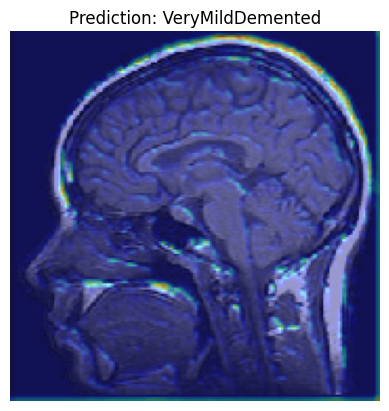

In [20]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

model = load_model("alzheimers_model.h5")
classes = ["MildDemented", "ModerateDemented", "NonDemented", "VeryMildDemented"]

img_path = "MRI_brain.jpg"
img = image.load_img(img_path, target_size=(176, 176))
img_array = image.img_to_array(img) / 255.0
img_array_exp = np.expand_dims(img_array, axis=0)

pred_index = np.argmax(model.predict(img_array_exp))

base_model = model.layers[0] 

last_conv_layer = None
for layer in reversed(base_model.layers):
    if 'conv' in layer.name:
        last_conv_layer = layer
        break

grad_model = tf.keras.models.Model(
    [base_model.input],
    [last_conv_layer.output, base_model.output]
)

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(img_array_exp)
    loss = predictions[:, pred_index]

grads = tape.gradient(loss, conv_outputs)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

conv_outputs = conv_outputs[0]
heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= tf.math.reduce_max(heatmap)

heatmap = cv2.resize(heatmap.numpy(), (176, 176))
heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

superimposed_img = cv2.addWeighted(cv2.cvtColor(np.uint8(img_array*255), cv2.COLOR_RGB2BGR), 0.6, heatmap, 0.4, 0)
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f"Prediction: {classes[pred_index]}")
plt.show()

In [21]:
import os

output_folder = "gradcam_outputs"
os.makedirs(output_folder, exist_ok=True)
output_path = os.path.join(output_folder, "gradcam_" + os.path.basename(img_path))
cv2.imwrite(output_path, superimposed_img)
print(f"Grad-CAM saved at {output_path}")

Grad-CAM saved at gradcam_outputs\gradcam_MRI_brain.jpg


In [22]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

model = load_model("alzheimers_model.h5")
classes = ["MildDemented", "ModerateDemented", "NonDemented", "VeryMildDemented"]

input_folder = "sample_mri"
output_folder = "gradcam_outputs"
os.makedirs(output_folder, exist_ok=True)

for root, dirs, files in os.walk(input_folder):
    for file in files:
        img_path = os.path.join(root, file)
        img = image.load_img(img_path, target_size=(176, 176))
        img_array = image.img_to_array(img) / 255.0
        img_array_exp = np.expand_dims(img_array, axis=0)

        pred_probs = model.predict(img_array_exp)
        pred_index = np.argmax(pred_probs)
        confidence = pred_probs[0][pred_index]

        base_model = model.layers[0]
        last_conv_layer = None
        for layer in reversed(base_model.layers):
            if 'conv' in layer.name:
                last_conv_layer = layer
                break

        grad_model = tf.keras.models.Model(
            [base_model.input],
            [last_conv_layer.output, base_model.output]
        )

        with tf.GradientTape() as tape:
            conv_outputs, predictions = grad_model([img_array_exp])
            loss = predictions[:, pred_index]

        grads = tape.gradient(loss, conv_outputs)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        conv_outputs = conv_outputs[0]
        heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
        heatmap = np.maximum(heatmap, 0)
        heatmap /= tf.math.reduce_max(heatmap)
        heatmap = cv2.resize(heatmap.numpy(), (176, 176))
        heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

        superimposed_img = cv2.addWeighted(
            cv2.cvtColor(np.uint8(img_array*255), cv2.COLOR_RGB2BGR), 0.6, heatmap, 0.4, 0
        )

        save_path = os.path.join(output_folder, "gradcam_" + file)
        cv2.imwrite(save_path, superimposed_img)

        print(f"Image: {file}, Predicted: {classes[pred_index]}, Confidence: {confidence:.2f}, Saved: {save_path}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


C:\Users\mohit\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_5']]
Received: inputs=['Tensor(shape=(1, 176, 176, 3))']
  warnings.warn(msg)


Image: MildImpairment (1).jpg, Predicted: NonDemented, Confidence: 0.51, Saved: gradcam_outputs\gradcam_MildImpairment (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
Image: MildImpairment (2).jpg, Predicted: MildDemented, Confidence: 0.76, Saved: gradcam_outputs\gradcam_MildImpairment (2).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
Image: MildImpairment (3).jpg, Predicted: NonDemented, Confidence: 0.48, Saved: gradcam_outputs\gradcam_MildImpairment (3).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
Image: MildImpairment (4).jpg, Predicted: NonDemented, Confidence: 0.96, Saved: gradcam_outputs\gradcam_MildImpairment (4).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Image: MildImpairment (5).jpg, Predicted: NonDemented, Confidence: 0.81, Saved: gradcam_outputs\gradcam_MildImpairment (5).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Image: ModerateImpairment (1).jpg, Predicted: ModerateDemented, Confidence: 0.56, Saved: gradcam_outputs\gradcam_ModerateImpairment (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1